In [19]:
# uncomment this to use CPU instead of GPU
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Variational Convolutional Autoencoder

Some references:
- https://arxiv.org/pdf/1606.05908.pdf
- https://www.youtube.com/watch?v=Tc-XfiDPLf4
- https://towardsdatascience.com/variational-inference-derivation-of-the-variational-autoencoder-vae-loss-function-a-true-story-3543a3dc67ee

In [31]:
import tensorflow as tf
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
import requests
import pandas as pd
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.manifold import TSNE
from functools import reduce
from tensorflow import keras as keras
from matplotlib import gridspec


In [3]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping

In [4]:
from tensorflow.keras.datasets import mnist

### Load MNIST dataset

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


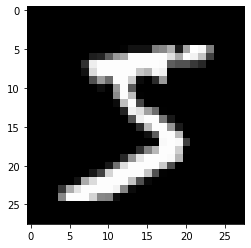

In [7]:
plt.figure()
plt.imshow(x_train[0, :, :, 0], cmap='gray')

#### reparameterization trick
instead of sampling from $Q(z|X)$, sample $\epsilon = N(0,I)$

This reparametrizatoin trick allows to backpropagate.

`z = z_mean + sqrt(var) * epsilon`


In [8]:
from tensorflow.keras import backend as K
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [9]:
batch_size = 100
img_width = x_train.shape[1]
img_height = x_train.shape[2]
channels = x_train.shape[3] # images are in black and white, for RGB we have 3 channels (r,g,b)

### Variational Convolutional Autoencoder architecture

In [10]:
latent_dim = 50
conv_shape = (3, 3)

Encoder

In [11]:
input_img = Input(shape=(img_width, img_height, channels))
x = Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu')(input_img)
x = Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu')(x)
x = Flatten()(x)
x = Dense(2 * latent_dim)(x)
x_split = tf.split(x, num_or_size_splits=2, axis=1, name='split')
z = Lambda(sampling, output_shape=(latent_dim,), name='z')(x_split)

#### decoder

In [12]:
input_gen = Input(shape=(latent_dim,))
y = Dense(units=32*7*7, activation='relu')(input_gen)
y = keras.layers.Reshape((7,7,32))(y)
y = keras.layers.Conv2DTranspose(
    filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu')(y)
y = keras.layers.Conv2DTranspose(
    filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu')(y)
y = keras.layers.Conv2DTranspose(
    filters=1, kernel_size=3, strides=(1, 1), padding="SAME")(y)

In [13]:
encoder = Model(input_img, [x_split[0], x_split[1], z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 13, 13, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 6, 6, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 2304)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [14]:
decoder = Model(input_gen, y)
decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1568)              79968     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 117,217
Trainable params: 117,217
Non-trainable params: 0
_______________________________________________________

In [15]:
output = decoder(encoder(input_img)[2])
vae = Model(input_img, output)
vae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              [(None, 50), (None, 50),  249316    
_________________________________________________________________
model (Model)                (None, 28, 28, 1)         117217    
Total params: 366,533
Trainable params: 366,533
Non-trainable params: 0
_________________________________________________________________


#### generate loss
some references:
- https://keras.io/examples/variational_autoencoder/
- https://arxiv.org/pdf/1312.6114.pdf

In [16]:
reconstruction_loss = keras.losses.mse(keras.layers.Flatten()(input_img), keras.layers.Flatten()(output))
reconstruction_loss *= 28*28

kl_loss = 1 + x_split[1] - K.square(x_split[0]) - K.exp(x_split[1])
kl_loss = K.sum(kl_loss, axis=1)
kl_loss = -0.5 * kl_loss
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

vae.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 50), (None,  249316      input_1[0][0]                    
__________________________________________________________________________________________________
model (Model)                   (None, 28, 28, 1)    117217      encoder[1][2]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 13, 13, 32)   320         input_1[0][0]                    
____________________________________________________________________________________________

In [17]:
log_dir = "./logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_cb = TensorBoard(
    log_dir=log_dir, 
    profile_batch=0)

es_cb = EarlyStopping(
    monitor='val_loss',
    verbose=True,
    patience=12,
    min_delta=0.0001, 
    restore_best_weights=True)

lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    verbose=True,
    patience=8,
    mi_delta=0.0001)

cb = [tb_cb, es_cb, lr_cb]

In [18]:
epochs = 200

autoencoder_train = vae.fit(
    x=x_train, 
    batch_size=batch_size,
    epochs=epochs, 
    shuffle=True,
    validation_data=(x_test, None),
    callbacks=cb)

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 37s 624us/sample - loss: 41.1002 - val_loss: 34.3653
Epoch 2/200
60000/60000 [==============================] - 37s 609us/sample - loss: 33.1894 - val_loss: 31.8863
Epoch 3/200
60000/60000 [==============================] - 37s 614us/sample - loss: 31.7591 - val_loss: 31.1271
Epoch 4/200
60000/60000 [==============================] - 37s 625us/sample - loss: 30.9976 - val_loss: 30.4100
Epoch 5/200
60000/60000 [==============================] - 37s 622us/sample - loss: 30.5322 - val_loss: 30.0824
Epoch 6/200
60000/60000 [==============================] - 37s 619us/sample - loss: 30.1876 - val_loss: 29.8247
Epoch 7/200
60000/60000 [==============================] - 37s 621us/sample - loss: 29.8895 - val_loss: 29.6066
Epoch 8/200
60000/60000 [==============================] - 37s 624us/sample - loss: 29.7515 - val_loss: 29.5314
Epoch 9/200
60000/60000 [=============================

Epoch 72/200
60000/60000 [==============================] - 35s 586us/sample - loss: 27.0400 - val_loss: 27.1328
Epoch 73/200
60000/60000 [==============================] - 36s 595us/sample - loss: 27.0152 - val_loss: 27.1119
Epoch 74/200
60000/60000 [==============================] - 35s 591us/sample - loss: 27.0257 - val_loss: 27.1623
Epoch 75/200
60000/60000 [==============================] - 36s 592us/sample - loss: 27.0252 - val_loss: 27.0938
Epoch 76/200
60000/60000 [==============================] - 35s 590us/sample - loss: 27.0258 - val_loss: 27.0867
Epoch 77/200
60000/60000 [==============================] - 35s 585us/sample - loss: 27.0269 - val_loss: 27.0385
Epoch 78/200
60000/60000 [==============================] - 35s 584us/sample - loss: 27.0088 - val_loss: 27.0943
Epoch 79/200
60000/60000 [==============================] - 36s 592us/sample - loss: 26.9936 - val_loss: 27.0971
Epoch 80/200
60000/60000 [==============================] - 36s 592us/sample - loss: 27.0004 - v

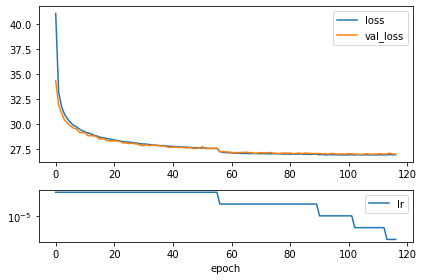

In [33]:
plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax1 = plt.subplot(gs[0])
plt.plot(autoencoder_train.history['loss'], label='loss')
plt.plot(autoencoder_train.history['val_loss'], label='val_loss')
plt.legend()
ax2 = plt.subplot(gs[1])
plt.plot(autoencoder_train.history['lr'], label='lr')
plt.legend()
ax2.set_xlabel('epoch')
ax2.set_yscale('log')
plt.tight_layout()

In [34]:
saved = False
if not saved:
    vae.save('./vae_keras_model_{}.hdf5'.format(epochs))
    encoder.save('./vae_encoder_keras_model_{}.hdf5'.format(epochs))
    decoder.save('./vae_decoder_keras_model_{}.hdf5'.format(epochs))    
    saved = True



### load model

In [36]:
# loaded_model = tf.keras.models.load_model('./vae_model_100.hdf5')

In [37]:
# loaded_model.layers

### Visualization of the latent space
The mean and the variance distributions may have a defined structure in the latent space, but $z$ in principle has a multidimensional unit normal distribution.

In [56]:
import seaborn as sns
from sklearn.metrics import silhouette_score

In [51]:
latents = encoder.predict(x_test)
latent_mu, latent_var, latent_z = latents[0], latents[1], latents[2]

In [54]:
latents_tsnes = {}
for data, which in zip(latents, ['mu', 'var', 'z']):
    latent_tsne = sklearn.manifold.TSNE(n_components=2, random_state=2).fit_transform(data)
    latent_df = pd.DataFrame({
            'x': latent_tsne[:, 0],
            'y': latent_tsne[:, 1],
            'label': y_test})
    latents_tsnes[which] = latent_df

score: 0.4636455476284027
score: 0.3552183210849762
score: -0.0955909788608551


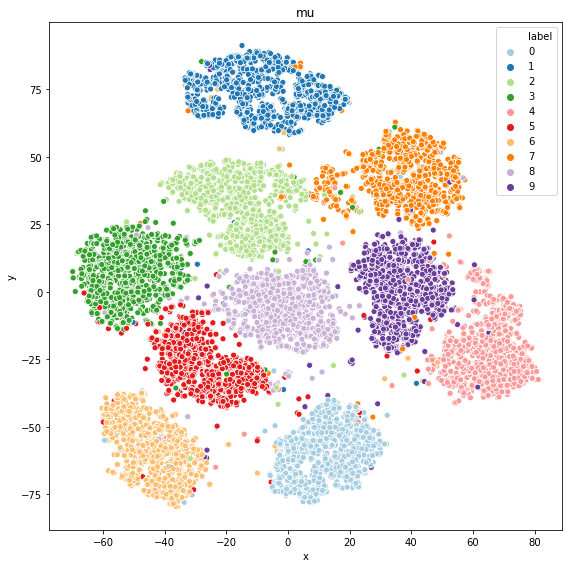

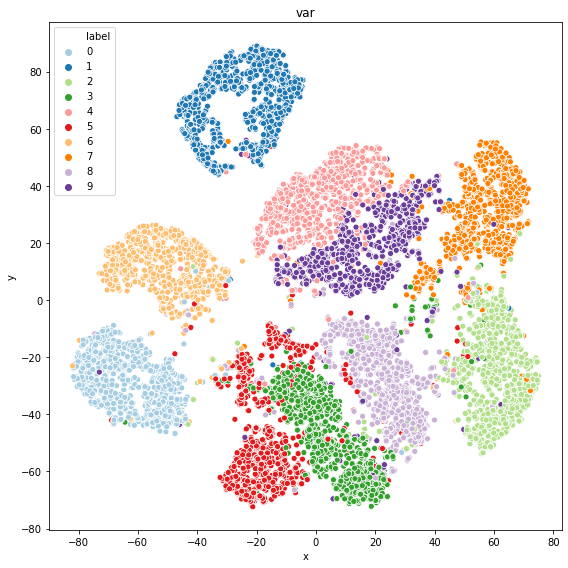

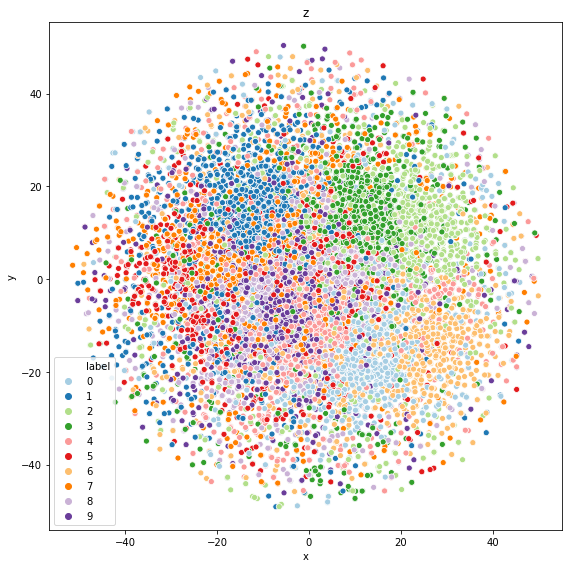

In [59]:
for which in ['mu', 'var', 'z']:
    latent_data = latents_tsnes[which]
    print('score: {}'.format(silhouette_score(latent_data[['x', 'y']].values, latent_data['label'].values )))
    fig = plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(x='x', y='y', hue='label', data=latent_data, palette='Paired')
    ax.set_title(which)
    plt.tight_layout()

#### Generate samples

Differently to a traditional autoencoder, where some points of the latent do not represent do not generate meaningful results, all the latent space of the variational autoencoder should generate meaningful results.

Additionally we force the latent space to be a $\mathcal{N}(0,1$}, so if we draw samples from this distribution and we use them to as the input of the decoder, the decoder should generate meaningful outputs.

In [60]:
n_examples = 16

In [61]:
examples = tf.random.normal(shape=[n_examples, latent_dim])

In [62]:
generated = decoder.predict(examples)

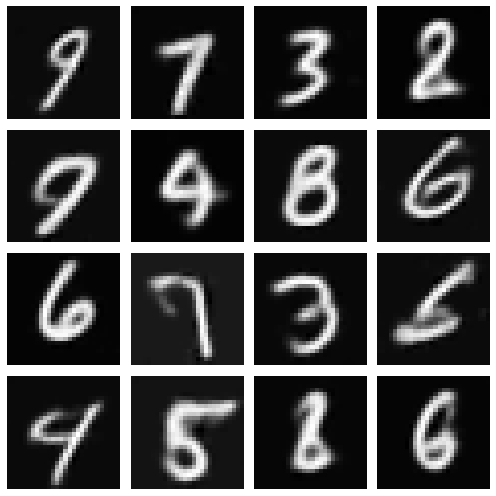

In [64]:
plt.figure(figsize=(7,7))
for i, gen in enumerate(generated):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(gen[:,:,0], cmap='gray')
    ax.axis('off')
    plt.tight_layout()